In [1]:
import os
import sys
sys.path.append("..")
import time
import numpy as np
import scipy.io.wavfile as wav
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
import torchvision


from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files
from models import SNN, SpikingConv2DLayer, SpikingDenseLayer#, ReadoutLayer
# from models import SpikingConv3DLayer, ReadoutLayer, SurrogateHeaviside

from data import SpeechCommandsDataset,Pad, MelSpectrogram, Rescale
from optim import RAdam

In [2]:
from data_augmentor import data_augment, batchify
from time_expector import TimeExpector
from notify import notify
from sklearn.model_selection import train_test_split
te = TimeExpector()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=wav.WavFileWarning)

In [4]:
# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")
    
dtype = torch.float

using cpu...


In [5]:
train_data_root = "data/train"
test_data_root = "data/test"

training_words = os.listdir(train_data_root)
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x))]
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x)) if x[0] != "_" ]
print("{} training words:".format(len(training_words)))
print(training_words)

30 training words:
['right', 'eight', 'cat', 'tree', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'off', 'four']


In [6]:
testing_words = os.listdir(test_data_root)
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x))]
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x)) 
                 if x[0] != "_"]
print("{} testing words:".format(len(testing_words)))
print(testing_words)

10 testing words:
['right', 'go', 'no', 'left', 'stop', 'up', 'down', 'yes', 'on', 'off']


In [7]:
label_dct = {k:i for i,k in enumerate(testing_words + ["_silence_", "_unknown_"])}
for w in training_words:
    label = label_dct.get(w)
    if label is None:
        label_dct[w] = label_dct["_unknown_"]

print("label_dct:")
print(label_dct)

label_dct:
{'right': 0, 'go': 1, 'no': 2, 'left': 3, 'stop': 4, 'up': 5, 'down': 6, 'yes': 7, 'on': 8, 'off': 9, '_silence_': 10, '_unknown_': 11, 'eight': 11, 'cat': 11, 'tree': 11, 'bed': 11, 'happy': 11, 'dog': 11, 'wow': 11, 'nine': 11, 'three': 11, 'sheila': 11, 'one': 11, 'bird': 11, 'zero': 11, 'seven': 11, 'marvin': 11, 'two': 11, 'house': 11, 'six': 11, 'five': 11, 'four': 11}


In [8]:
sr = 16000
size = 16000

In [9]:
noise_path = os.path.join(train_data_root, "_background_noise_")
noise_files = []
for f in os.listdir(noise_path):
    if f.endswith(".wav"):
        full_name = os.path.join(noise_path, f)
        noise_files.append(full_name)
print("noise files:")
print(noise_files)

noise files:
['data/train/_background_noise_/pink_noise.wav', 'data/train/_background_noise_/white_noise.wav', 'data/train/_background_noise_/dude_miaowing.wav', 'data/train/_background_noise_/doing_the_dishes.wav', 'data/train/_background_noise_/exercise_bike.wav', 'data/train/_background_noise_/running_tap.wav']


In [10]:
# generate silence training and validation data

silence_folder = os.path.join(train_data_root, "_silence_")
if not os.path.exists(silence_folder):
    os.makedirs(silence_folder)
    # 260 validation / 2300 training
    generate_random_silence_files(2560, noise_files, size, os.path.join(silence_folder, "rd_silence"))

    # save 260 files for validation
    silence_files = [fname for fname in os.listdir(silence_folder)]
    with open(os.path.join(train_data_root, "silence_validation_list.txt"),"w") as f:
        f.writelines("_silence_/"+ fname + "\n" for fname in silence_files[:260])

In [11]:
n_fft = int(30e-3*sr)
hop_length = int(10e-3*sr)
n_mels = 40
fmax = 4000
fmin = 20
delta_order = 2
stack = True

melspec = MelSpectrogram(sr, n_fft, hop_length, n_mels, fmin, fmax, delta_order, stack=stack)
pad = Pad(size)
rescale = Rescale()


transform = torchvision.transforms.Compose([pad,
                                 melspec,
                                 rescale])


def collate_fn(data):
    X_batch = np.array([d[0] for d in data])
    std = X_batch.std(axis=(0,2), keepdims=True)
    X_batch = torch.tensor(X_batch/std)
    
    y_batch = torch.tensor([d[1] for d in data])
    
    return X_batch, y_batch

In [12]:
batch_size = 16

# train_dataset = SpeechCommandsDataset(train_data_root, label_dct, transform = transform, mode="train", max_nb_per_class=None)
# train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.weights,len(train_dataset.weights))
# # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, sampler=train_sampler, collate_fn=collate_fn)

# valid_dataset = SpeechCommandsDataset(train_data_root, label_dct, transform = transform, mode="valid", max_nb_per_class=None)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

# test_dataset = SpeechCommandsDataset(test_data_root, label_dct, transform = transform, mode="test")
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
# train_dataloader = test_dataloader

In [13]:
CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached/"
DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture/"

def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation
    )

In [14]:
class SurrogateHeaviside(torch.autograd.Function):
    # Activation function with surrogate gradient
    sigma = 10.0

    @staticmethod
    def forward(ctx, input):
        output = torch.zeros_like(input)
        output[input > 0] = 1.0
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # approximation of the gradient using sigmoid function
        grad = grad_input * torch.sigmoid(SurrogateHeaviside.sigma * input) * torch.sigmoid(
            -SurrogateHeaviside.sigma * input)
        return grad


In [15]:
class ReadoutLayer(torch.nn.Module):
    def __init__(self, input_shape, output_shape, w_init_mean, w_init_std, eps=1e-8, time_reduction="mean"):

        assert time_reduction in ["mean", "max"], 'time_reduction should be "mean" or "max"'

        super(ReadoutLayer, self).__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.eps = eps
        self.time_reduction = time_reduction

        self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
#         self.w = torch.nn.Parameter(torch.empty((10, 20)), requires_grad=True)
        if time_reduction == "max":
            self.beta = torch.nn.Parameter(torch.tensor(0.7 * np.ones((1))), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

        self.reset_parameters()
        self.clamp()

        self.mem_rec_hist = None

    def forward(self, x):
#         print('readout step')
#         print("~~~~~~~~~~~ readout ~~~~~~~~~~~")
        batch_size = x.shape[0]

#         print('x.shape=', x.shape)
#         print('w.shape=', self.w.shape)
        
        h = torch.einsum("abc,cd->abd", x, self.w)
        
#         print('after einsum')
        
        norm = (self.w ** 2).sum(0)

        if self.time_reduction == "max":
            nb_steps = x.shape[1]
            # membrane potential 
            mem = torch.zeros((batch_size, self.output_shape), dtype=x.dtype, device=x.device)

            # memrane potential recording
            mem_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)

            for t in range(nb_steps):
                # membrane potential update
                mem = mem * self.beta + (1 - self.beta) * h[:, t, :]
                mem_rec[:, t, :] = mem

            output = torch.max(mem_rec, 1)[0] / (norm + 1e-8) - self.b

        elif self.time_reduction == "mean":

            mem_rec = h
            output = torch.mean(mem_rec, 1) / (norm + 1e-8) - self.b

#         print('almost end of readout')
            
        # save mem_rec for plotting
        self.mem_rec_hist = mem_rec.detach().cpu().numpy()

        loss = None

        return output, loss

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean,
                              std=self.w_init_std * np.sqrt(1. / np.prod(self.input_shape)))

        if self.time_reduction == "max":
            torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)

        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):

        if self.time_reduction == "max":
            self.beta.data.clamp_(0., 1.)

In [16]:
class SpikingConv3DLayer(torch.nn.Module):
    def __init__(self, input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean, w_init_std, recurrent=False,
                 lateral_connections=True,
                 eps=1e-8, stride=(1, 1, 1), flatten_output=False):

        super(SpikingConv3DLayer, self).__init__()

        self.kernel_size = np.array(kernel_size)
        self.dilation = np.array(dilation)
        self.stride = np.array(stride)
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.lateral_connections = lateral_connections
        self.eps = eps

        self.flatten_output = flatten_output

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((out_channels, in_channels, *kernel_size)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((out_channels, out_channels)), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(out_channels), requires_grad=True)

        self.reset_parameters()
        self.clamp()

        self.spk_rec_hist = None

        self.training = True

    def forward(self, x):
#         print("~~~~~~~~~~~ 3d forwad ~~~~~~~~~~~")
        batch_size = x.shape[0]

        
        stride=tuple(self.stride)
        padding=tuple(np.ceil(((self.kernel_size - 1) * self.dilation) / 2).astype(int))
#         print('stride', stride)
#         print('padding', padding)
        
#         print('---------------> x.shape=', x.shape)
#         print('---------------> w.shape=', self.w.shape)
        
        conv_x = torch.nn.functional.conv3d(x, self.w, padding=padding,
                                            dilation=tuple(self.dilation),
                                            stride=stride)
        
        conv_x = conv_x[:, :, :, :self.output_shape[0], :self.output_shape[1]]
        nb_steps = conv_x.shape[2]

        # membrane potential 
        mem = torch.zeros((batch_size, self.out_channels, *self.output_shape), dtype=x.dtype, device=x.device)
        # output spikes
        spk = torch.zeros((batch_size, self.out_channels, *self.output_shape), dtype=x.dtype, device=x.device)

        # output spikes recording
        spk_rec = torch.zeros((batch_size, self.out_channels, nb_steps, *self.output_shape), dtype=x.dtype,
                              device=x.device)

        if self.lateral_connections:
            d = torch.einsum("abcde, fbcde -> af", self.w, self.w)
        b = self.b.unsqueeze(1).unsqueeze(1).repeat((1, *self.output_shape))

        norm = (self.w ** 2).sum((1, 2, 3, 4))

        for t in range(nb_steps):
#             print('3d-step', t)
            # reset term
            if self.lateral_connections:
                rst = torch.einsum("abcd,be ->aecd", spk, d)
            else:
                rst = torch.einsum("abcd,b,b->abcd", spk, self.b, norm)

            input_ = conv_x[:, :, t, :, :]
            if self.recurrent:
                input_ = input_ + torch.einsum("abcd,be->aecd", spk, self.v)

            # membrane potential update
#             print('>>>>>>   rst.shape=', rst.shape)
#             print('>>>>>>   mem.shape=', mem.shape)
#             print('>>>>>>   sub.shape=', (mem - rst).shape)
#             print('>>>>>> input_.shape=', input_.shape)
            mem = (mem - rst) * self.beta + input_ * (1. - self.beta)
            mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b

            spk = self.spike_fn(mthr)

            spk_rec[:, :, t, :, :] = spk

            # save spk_rec for plotting
        self.spk_rec_hist = spk_rec.detach().cpu().numpy()

        loss = 0.5 * (spk_rec ** 2).mean()

        if self.flatten_output:
            output = torch.transpose(spk_rec, 1, 2).contiguous()
            output = output.view(batch_size, nb_steps, self.out_channels * np.prod(self.output_shape))
        else:
            output = spk_rec

        return output, loss

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean,
                              std=self.w_init_std * np.sqrt(1. / (self.in_channels * np.prod(self.kernel_size))))
        if self.recurrent:
            torch.nn.init.normal_(self.v, mean=self.w_init_mean,
                                  std=self.w_init_std * np.sqrt(1. / self.out_channels))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        self.beta.data.clamp_(0., 1.)
        self.b.data.clamp_(min=0.)

In [17]:
spike_fn = SurrogateHeaviside.apply
layers = []

w_init_std = 0.15
w_init_mean = 0.1

in_channels = 1
out_channels = 16
kernel_size = (1,3,3)
dilation = (1,1,1)
input_shape = (64, 64)

# kernel_size = (3,3)
# dilation = (1,1)
# input_shape = 64*64

output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv3DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True, 
                               flatten_output=True # <========================== I have added this line 
                            ))


# in_channels = out_channels
# out_channels = 64
# kernel_size = (4,3)
# dilation = (4,3)
# input_shape = output_shape
# output_shape = input_shape # padding mode is "same"
# layers.append(SpikingConv2DLayer(input_shape, output_shape,
#                  in_channels, out_channels, kernel_size, dilation,
#                  spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
#                               lateral_connections=True))

# in_channels = out_channels
# out_channels = 64
# kernel_size = (4,3)
# dilation = (16,9)
# input_shape = output_shape
# output_shape = input_shape # padding mode is "same"
# layers.append(SpikingConv2DLayer(input_shape, output_shape,
#                  in_channels, out_channels, kernel_size, dilation,
#                  spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
#                                lateral_connections=True, flatten_output=True))

# previous layer output has been flattened
input_shape = np.prod([output_shape[0], output_shape[1], out_channels])
# input_shape = output_shape*out_channels
print('-------------> input shape=', input_shape)
output_shape = 12
time_reduction="mean" # mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

for X_batch, _ in load_data('train'):
#     _X_batch, _ = next(iter(train_dataloader))
#     print('_x: ', _X_batch.shape)
    
    shp = X_batch.shape
    X_batch = np.reshape(X_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
    X_batch = torch.from_numpy(X_batch).to(device, dtype)
    print(' x: ', X_batch.shape)
    
    snn(X_batch)

    for i,l in enumerate(snn.layers):
        if isinstance(l, SpikingDenseLayer) or \
           isinstance(l, SpikingConv2DLayer) or \
           isinstance(l, SpikingConv3DLayer):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
    break
print('done')

-------------> input shape= 65536
 x:  torch.Size([16, 1, 100, 64, 64])
Layer 0: average number of spikes=0.0184
done


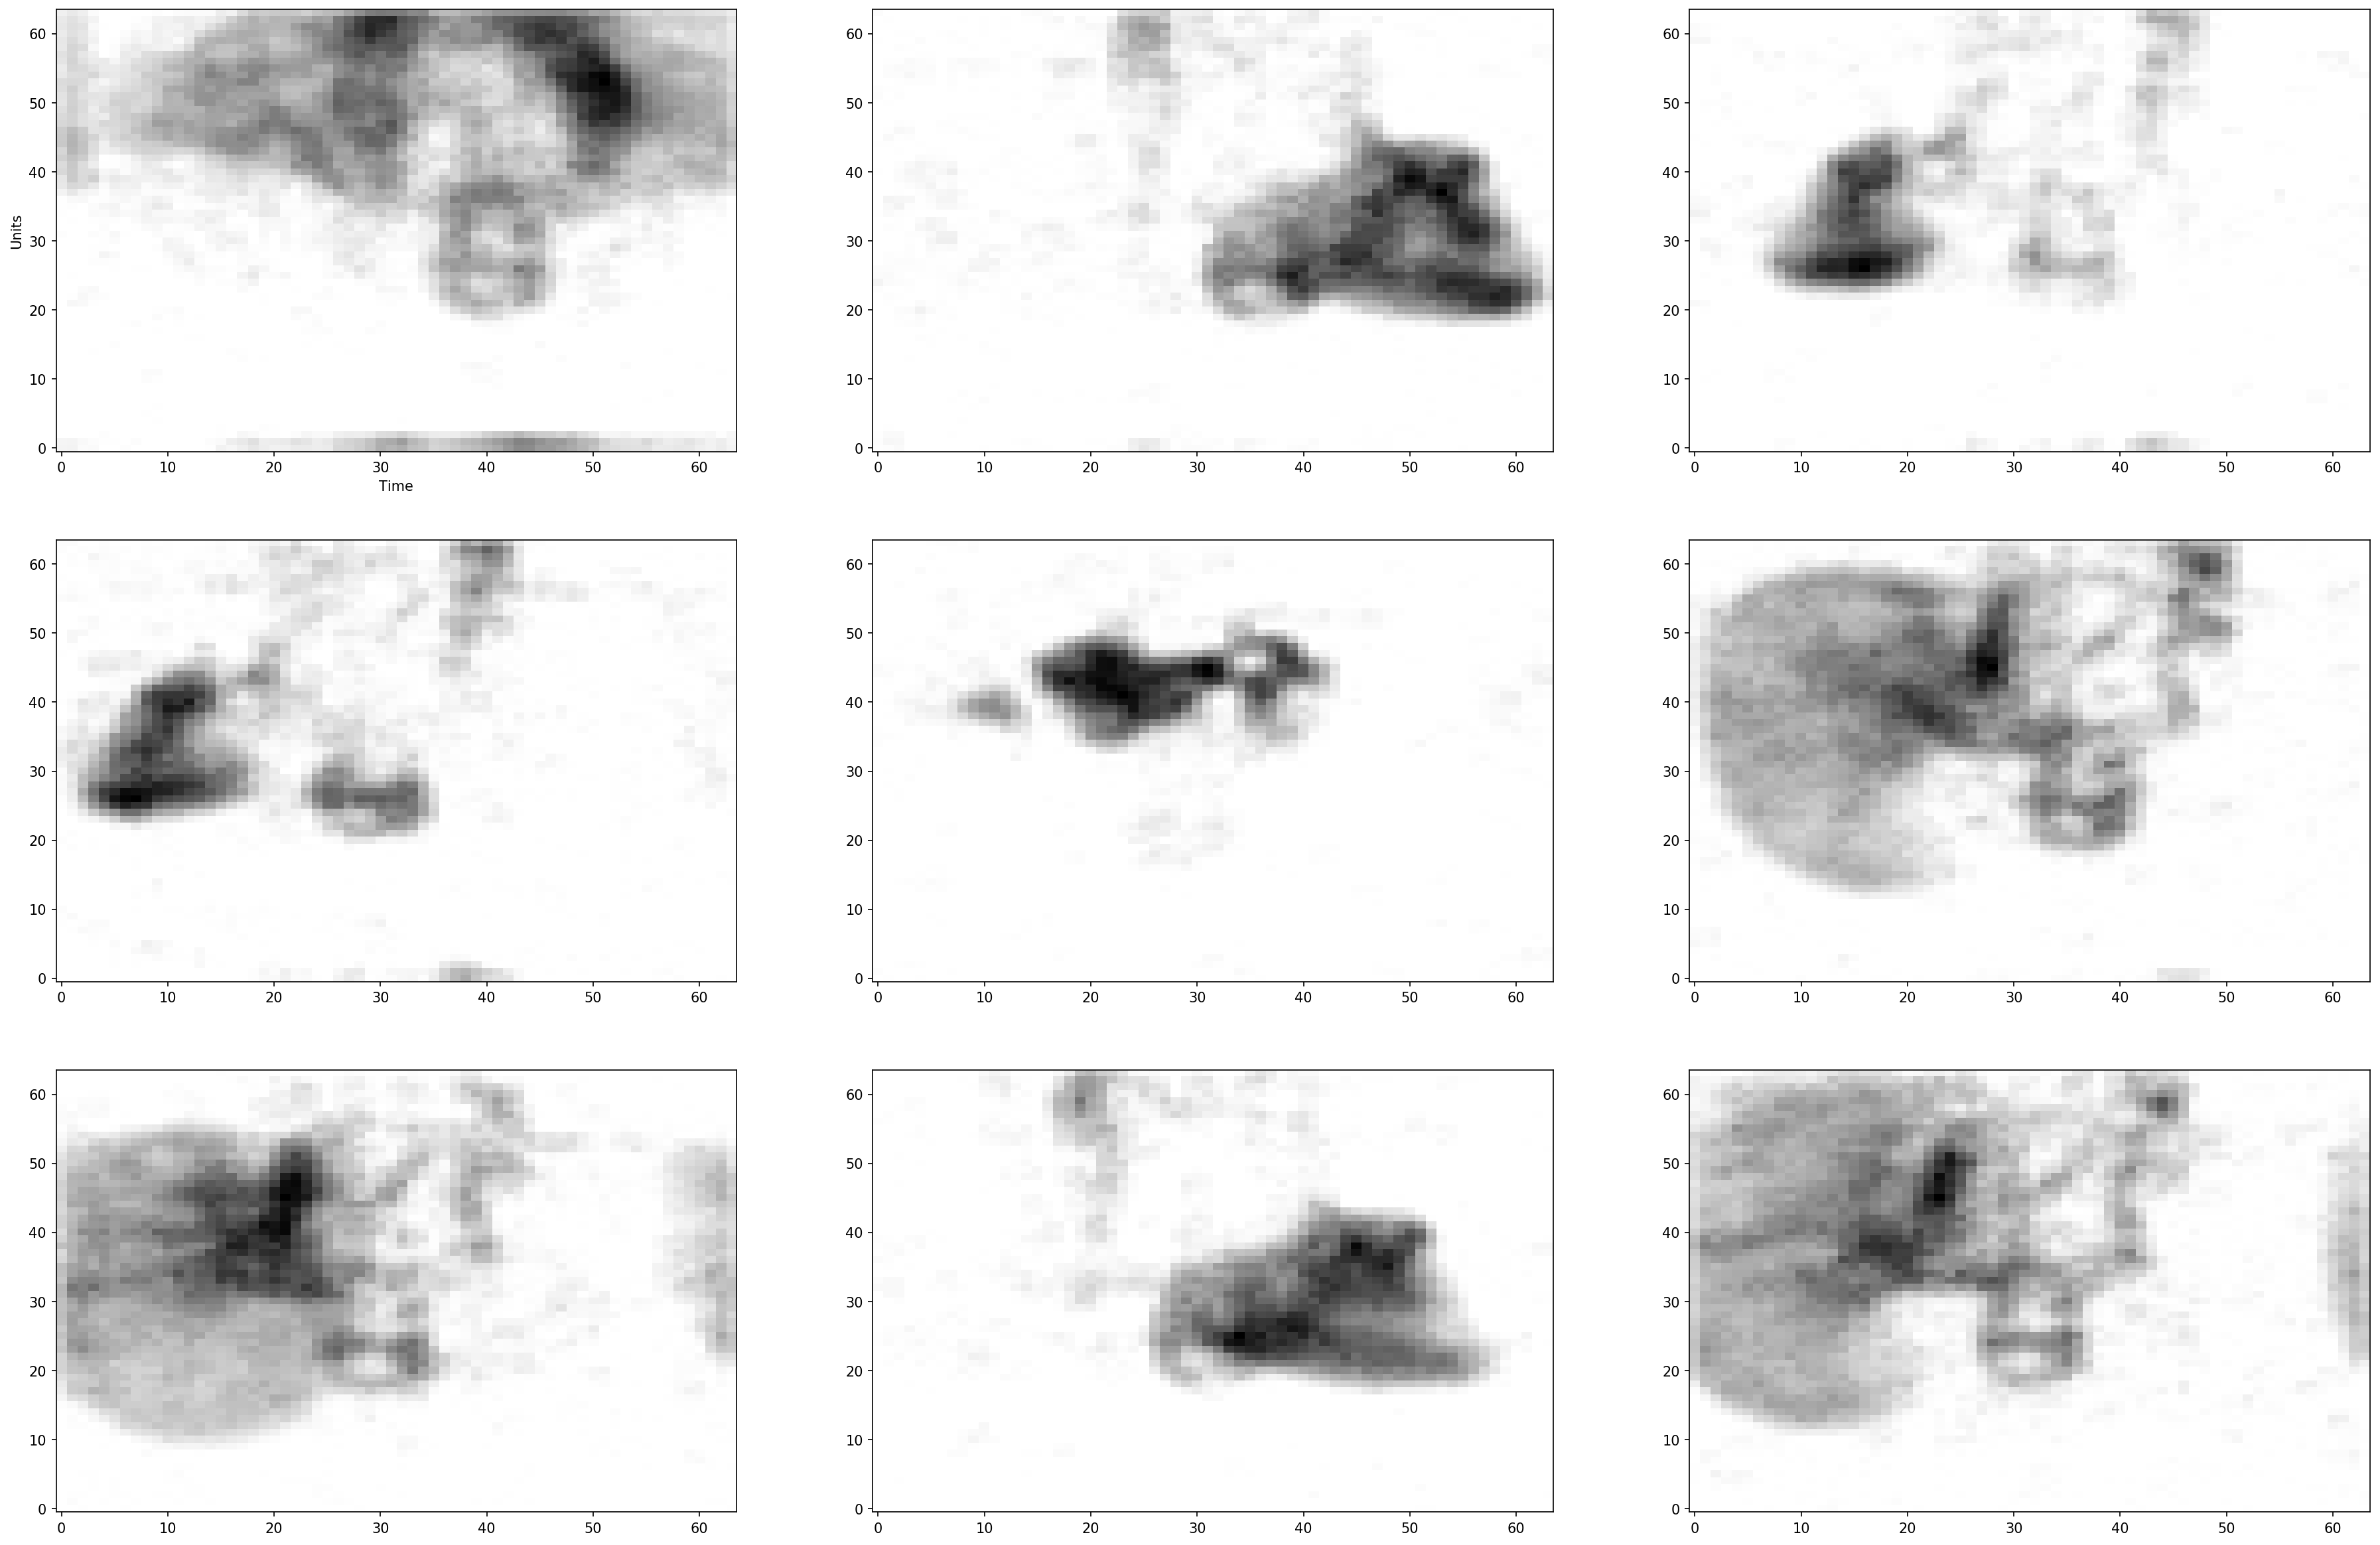

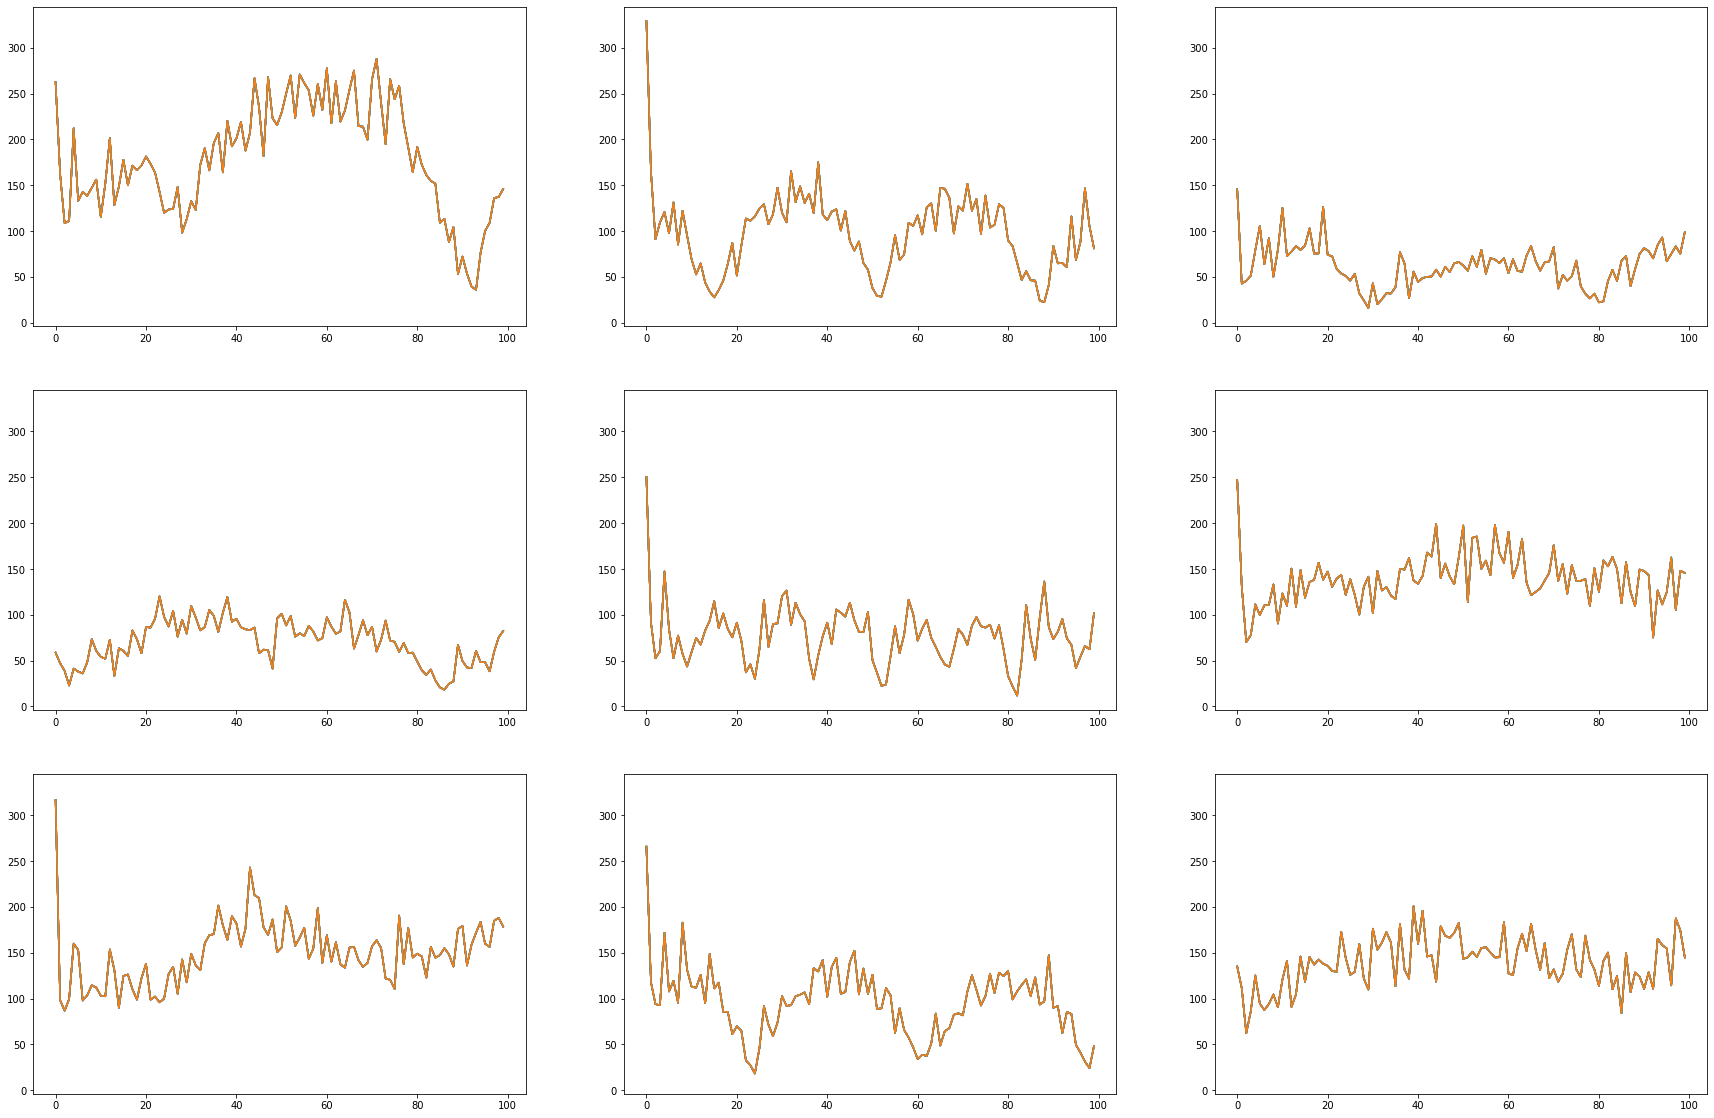

In [18]:
nb_plt = 9

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
#     print('layer', i)
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    elif isinstance(l, SpikingConv3DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1).sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [19]:
def train(model, params, optimizer, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= 1000*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[], 'valid_accuracy':[]}
    for e in range(nb_epochs):
        te.tick(nb_epochs-e)
        print('\n')
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        #with tqdm_notebook(total=len(train_dataloader)) as pb:
        e_2 = 0
        for x_batch, y_batch in load_data('train'):
            e_2 += 1
            print('\r%d -- %d' % (e, e_2), end='')
            shp = x_batch.shape
            x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
        
        
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)

#             print('a')
            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

#             print('b')
#             for i,loss in enumerate(loss_seq[:-1]):
#                 print('  -', i)
#                 reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
#                 loss_val += reg_loss_val
#                 reg_loss[i].append(reg_loss_val.item())


#             print('c')
            optimizer.zero_grad()
#             print('d')
            loss_val.backward()
#             print('e')
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
#             print('f')
            optimizer.step()
#             print('g')
            model.clamp()
#             print('h')
            
            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                #pb.update(1)
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy = compute_classification_accuracy(model, 'test')
        hist['valid_accuracy'].append(valid_accuracy)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        te.tock()
        
    return hist
        
def compute_classification_accuracy(model, trail):
    accs = []
    
    with torch.no_grad():
        #with tqdm_notebook(total=len(dataloader)) as pb:
        for x_batch, y_batch in load_data(trail):
            shp = x_batch.shape
            x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
                #pb.update(1)
    return np.mean(accs)

In [20]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1
nb_epochs = 1

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
params += [{
    'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
if snn.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
elif snn.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

hist = train(snn, params, optimizer, reg_loss_coef, nb_epochs=nb_epochs,
                  scheduler=scheduler, warmup_epochs=1)



0 -- 373

KeyboardInterrupt: 

In [ ]:
test_accuracy = compute_classification_accuracy(snn, test_dataloader)
print("Test accuracy=%.3f"%(test_accuracy))

In [ ]:
snn(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)